Численные методы  
Лабораторная работа 6

$\dfrac{\partial^2 u}{\partial t^2} = a^2 \dfrac{\partial^2 u}{\partial x^2},~a^2>0$  
$u(0,t) = -\sin(a \cdot t)$  
$u(\pi,t) = \sin(a \cdot t)$  
$u(x,0) = \sin(x)$  
$u_t(x,0) = -a\cos(x)$

Решение: $u(x,t) = \sin(x - a \cdot t)$

Явная схема:

$\dfrac{u_{j}^{k+1} - 2u_j^k + u_{j}^{k-1}}{\tau^2} = a^2 \dfrac{u_{j+1}^{k} - 2u_j^k + u_{j-1}^{k}}{h^2} + O(\tau^2 + h^2)$

$u_j^{k+1} = 2u_j^k (1 - \sigma) + \sigma (u_{j+1}^k + u_{j-1}^k) - u_j^{k-1} + \tau^2 O(\tau^2 + h^2)$

где $\sigma = \left( \dfrac{a\tau}{h} \right)^2$

Неявная схема:

$\dfrac{u_{j}^{k+1} - 2u_j^k + u_{j}^{k-1}}{\tau^2} = a^2 \dfrac{u_{j-1}^{k+1} - 2u_j^{k+1} + u_{j+1}^{k+1}}{h^2} + O(\tau + h^2)$

$a_j \cdot u_{j-1}^{k+1} + b_j \cdot u_{j}^{k+1} + c_j \cdot u_{j+1}^{k+1} = d_j,~~j=\overline{1,N-1}$

где $a_j = 1,~~b_j = -2-1/\sigma,~~c_j = 1,~~d_j = (u_{j}^{k-1} - 2u_{j}^{k})/\sigma$

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def cond_1(t, a = 1.0):
    return -math.sin(a * t)

def cond_2(t, a = 1.0):
    return math.sin(a * t)

def init_cond_1(x, a = 1.0):
    return math.sin(x)

def init_cond_2(x, a = 1.0):
    return -a * math.cos(x)

def diff2_init_cond(x, a = 1.0):
    return -math.sin(x)

def analytical_solution(x, t, a = 1.0):
    return math.sin(x - a * t)

Явная схема:

In [3]:
l_start = 0.0
l_finish = math.pi
t_start = 0.0
t_finish = 1.0

def explicit(N = 30, K = 300, a = 1.0):
    N = N - 1
    K = K - 1
    h = (l_finish - l_start) / N
    tau = (t_finish - t_start) / K
    sigma = a * a * tau * tau / (h * h)
    X = []
    T = []
    ans = []
    
    x = list(np.linspace(l_start, l_finish, N))
    ans.append(list(map(init_cond_1, x, len(x)*[a])))
    ans.append(list(map(lambda lam: init_cond_1(lam, a) + tau*init_cond_2(lam, a) + a*a*tau*tau*diff2_init_cond(lam, a)/2, x)))
    X = [x, x]
    T.append([0.0 for _ in x])
    T.append([tau for _ in x])
    
    for t in np.linspace(t_start + 2*tau, t_finish, K):
        ans_last_line_1 = ans[-1]
        ans_last_line_2 = ans[-2]
        ans_line = [None for _ in ans_last_line_1]
        for i in range(1, len(x) - 1):
            ans_line[i] = 2 * (1 - sigma) * ans_last_line_1[i]
            ans_line[i] += sigma * (ans_last_line_1[i+1] + ans_last_line_1[i-1])
            ans_line[i] -= ans_last_line_2[i]
        ans_line[0] = cond_1(t, a)
        ans_line[-1] = cond_2(t, a)
        
        ans.append(ans_line)
        X.append(x)
        T.append([t for _ in x])
    
    return X, T, ans

Неявная схема:

In [4]:
def race_method(A, b):
    P = [-item[2] for item in A]
    Q = [item for item in b]
    eps = 1e-10 if abs(A[0][1]) < 1e-8 else 0
    P[0] /= (A[0][1] + eps)
    Q[0] /= (A[0][1] + eps)
    for i in range(1, len(b)):
        z = (A[i][1] + A[i][0] * P[i-1])
        P[i] /= (z + eps)
        Q[i] -= A[i][0] * Q[i-1]
        Q[i] /= (z + eps)
    x = [item for item in Q]
    for i in range(len(x) - 2, -1, -1):
        x[i] += P[i] * x[i + 1]
    return x

In [5]:
l_start = 0.0
l_finish = math.pi
t_start = 0.0
t_finish = 1.0

def implicit(N = 30, K = 300, a = 1.0):
    N = N - 1
    K = K - 1
    h = (l_finish - l_start) / N
    tau = (t_finish - t_start) / K
    sigma = a * a * tau * tau / (h * h)
    X = []
    T = []
    ans = []
    
    x = list(np.linspace(l_start, l_finish, N+1))
    ans.append(list(map(init_cond_1, x, len(x)*[a])))
    ans.append(list(map(lambda lam: init_cond_1(lam, a) + tau*init_cond_2(lam, a) + a*a*tau*tau*diff2_init_cond(lam, a)/2, x)))
    X = [x, x]
    T.append([0.0 for _ in x])
    T.append([tau for _ in x])
    
    for t in np.linspace(t_start + 2*tau, t_finish, K):
        ans_last_line_1 = ans[-1]
        ans_last_line_2 = ans[-2]
        coeff_a = 1
        coeff_b = -2 - 1 / sigma
        
        A = [
            (coeff_a, coeff_b, coeff_a)
            for _ in range(1, len(x)-1)
        ]
        coeff_d = [
            (ans_last_line_2[i] - 2 * ans_last_line_1[i]) / sigma
            for i in range(1, len(x) - 1)
        ]
        A.insert(0, (0, coeff_b, coeff_a))
        coeff_d.insert(0, (cond_1(t-tau, a) - 2*cond_1(t, a)) / sigma)
        
        A.append((coeff_a, coeff_b, 0))
        coeff_d.append((cond_2(t-tau, a) - 2*cond_2(t, a)) / sigma)
        
        ans.append(race_method(A, coeff_d))
        X.append(x)
        T.append([t for _ in x])
    
    return X, T, ans

# Вычисление погрешностей методов

Вычисление ошибки (норма матрицы ошибки):

In [6]:
def RMSE(x, t, approx, real_func, param_a = 1.0):
    ans = 0.0
    for i in range(len(approx)):
        for j in range(len(approx[i])):
            ans += (approx[i][j] - real_func(x[i][j], t[i][j], param_a))**2
    return (ans / (len(approx) * len(approx[i])))**0.5

In [7]:
def error_plot_data(solver, real_f, a = 1.0):
    h, e = [], []
    for N in range(5, 100):
        x, t, ans = solver(N=N, K = 20 * N, a=a)
        h.append(np.pi / N)
        e.append(RMSE(x, t, ans, real_f, a))
    return h, e

In [8]:
def error_plot(method, method_name):
    plt.title("Зависимость погрешности от длины шага по x и по t")
    h, e = error_plot_data(method, analytical_solution)
    
    plt.plot(h, e, label=method_name, color = "blue")
    plt.xlabel("h")
    plt.ylabel("ошибка")
    plt.legend()
    plt.grid()

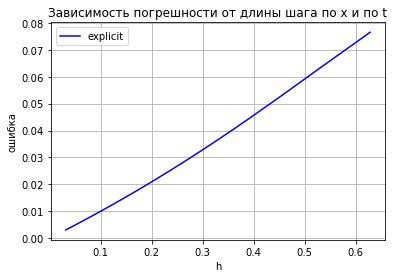

In [9]:
error_plot(explicit, "explicit")

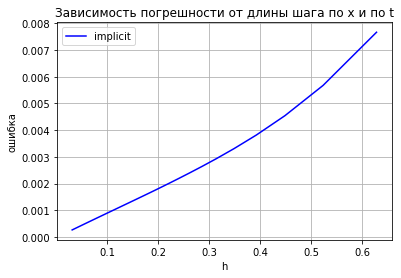

In [10]:
error_plot(implicit, "implicit")

In [11]:
def R3_plot(method, method_name):
    X_e, T_e, approx_e = method()
    z_plot = []
    for j in range(0, len(X_e), 1):
        tmp = []
        for i in range(0, len(X_e[j]), 1):
            tmp.append(analytical_solution(X_e[j][i], T_e[j][i]))
        z_plot.append(tmp)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_e, T_e, approx_e, label="alalytical", c='r')
    ax.scatter(X_e, T_e, z_plot, label=method_name, c='b')

    plt.legend()
    plt.grid()

    print("RMSE = ", RMSE(X_e, T_e, approx_e, analytical_solution))

RMSE =  0.010940135873761359


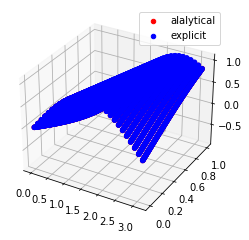

In [12]:
R3_plot(explicit, "explicit")

RMSE =  0.0018102814339126048


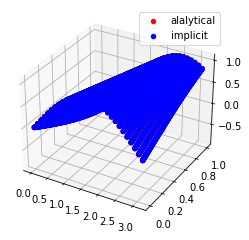

In [13]:
R3_plot(implicit, "implicit")